# **Exact Diagonalization on the One-Dimensional Quantum Clock Model**

### Code

In [2]:
import scipy.sparse.linalg as spla
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import namedtuple
from scipy.optimize import curve_fit

In [4]:
# Define operators
def clock_operators(q):
    """
    Define clock model operators for q-state system.
    
    Parameters:
    q: number of discrete states

    Returns:
    Clock and shift operator.
    """
    omega =  np.exp((2j * np.pi) / q)
    C = sp.csr_matrix(np.diag([omega ** m for m in range(q)]))
    S = sp.csr_matrix(np.roll(np.eye(q), shift=-1, axis=1))
    
    return C, S

def apply_operator_at_site(O, i, L, q):
    """
    Places an operator O at site i in an L-site q-state system.

    Parameters:
    O: operator to apply
    i: state index
    L: total number of sites
    q: number of discrete states per site

    Returns:
    The Kronecker product representing the operator acting on the full system.
    """
    L = int(L)
    if not (0 <= i < L):
        raise IndexError(f"Invalid site index i={i}. Must be between 0 and {L-1}")

    I_q = sp.identity(q, format="csr")
    op_list = [I_q] * L  # List of identity operators
    op_list[i] = O  # Apply operator at correct site

    # Compute the full Kronecker product
    full_operator = op_list[0]
    for op in op_list[1:]:
        full_operator = sp.kron(full_operator, op, format="csr")

    return full_operator

In [6]:
# Define Hamiltonian
def clock_hamiltonian(q, J, h, L, periodic = False):
    """
    Parameters:
    q: number of discrete states
    C: clock operator
    S: shift operator
    J: coupling constant
    h: external field strength
    L: number of sites
    """
    L = int(L)

    C, S = clock_operators(q)
    H = sp.csr_matrix((q**L, q**L))

    for i in range(1, L):
        H += (-J) * ((apply_operator_at_site(S, i-1, L, q) @ apply_operator_at_site(S.H, i, L, q)) 
             + (apply_operator_at_site(S.H, i-1, L, q) @ apply_operator_at_site(S, i, L, q)))
        H += (-J * (h / (2 * J))) * (apply_operator_at_site(C, i-1, L, q) + apply_operator_at_site(C.H, i-1, L, q) 
                                     + apply_operator_at_site(C, i, L, q) + apply_operator_at_site(C.H, i, L, q))

    if periodic:
        H += (-J) * ((apply_operator_at_site(S, L-1, L, q) @ apply_operator_at_site(S.H, 0, L, q)) 
                                 + (apply_operator_at_site(S.H, L-1, L, q) @ apply_operator_at_site(S, 0, L, q)))
    H += (-J * (h / (2 * J))) * (apply_operator_at_site(C, 0, L, q) + apply_operator_at_site(C.H, 0, L, q) 
                                 + apply_operator_at_site(C, L-1, L, q) + apply_operator_at_site(C.H, L-1, L, q))
    return H

In [8]:
# Ground-state energy density
def E0_per_site(q, J, h, L):
    H = clock_hamiltonian(q, J, h, L)
    eigval = spla.eigsh(H, k=1, which='SA', return_eigenvectors=False)  # Use eigsh for real Hermitian
    E0 = np.real(eigval[0])
    return E0 / L

In [10]:
# Energy gap per site
def E0_and_E1_per_site(q, J, h, L):
    H = clock_hamiltonian(q, J, h, L)
    eigval = spla.eigsh(H, k=2, which='SA', return_eigenvectors=False)  # Use eigsh for real Hermitian
    E0 = np.real(eigval[0])
    E1 = np.real(eigval[1])
    return np.abs(E1 - E0) / L

### Sample Calculations

In [84]:
q = 2  # Number of discrete states per site
h = 1.0  # External field
J = 1.0  # Coupling constant
L = 10  # Number of sites

start_time = time.time()
E0 = E0_per_site(q, J, h, L)
print(f"Ground-state energy per site: {E0}")
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

Ground-state energy per site: -2.4762979999309467
Total runtime: 0.39 seconds


In [82]:
q = 3  # Number of discrete states per site
h = 1.0  # External field
J = 1.0  # Coupling constant
L = 10  # Number of sites

start_time = time.time()
E1_minus_E0 = E0_and_E1_per_site(q, J, h, L)
print(f"Energy gap per site: {E1_minus_E0}")
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

Energy gap per site: 0.049492693883932404
Total runtime: 1.86 seconds


### Extrapolation (Finite-Size Scaling)

h	1/L	E0/L
0.25	0.5000	2.0616
0.25	0.2500	2.0320
0.25	0.1667	2.0314
0.25	0.1250	2.0314
0.25	0.1000	2.0314
0.50	0.5000	2.2361
0.50	0.2500	2.1358
0.50	0.1667	2.1282
0.50	0.1250	2.1273
0.50	0.1000	2.1271
0.75	0.5000	2.5000
0.75	0.2500	2.3280
0.75	0.1667	2.3033
0.75	0.1250	2.2967
0.75	0.1000	2.2944
1.00	0.5000	2.8284
1.00	0.2500	2.6131
1.00	0.1667	2.5758
1.00	0.1250	2.5629
1.00	0.1000	2.5570
1.25	0.5000	3.2016
1.25	0.2500	2.9724
1.25	0.1667	2.9370
1.25	0.1250	2.9266
1.25	0.1000	2.9227
1.50	0.5000	3.6056
1.50	0.2500	3.3800
1.50	0.1667	3.3523
1.50	0.1250	3.3463
1.50	0.1000	3.3446
1.75	0.5000	4.0311
1.75	0.2500	3.8168
1.75	0.1667	3.7964
1.75	0.1250	3.7930
1.75	0.1000	3.7923
2.00	0.5000	4.4721
2.00	0.2500	4.2716
2.00	0.1667	4.2565
2.00	0.1250	4.2545
2.00	0.1000	4.2542


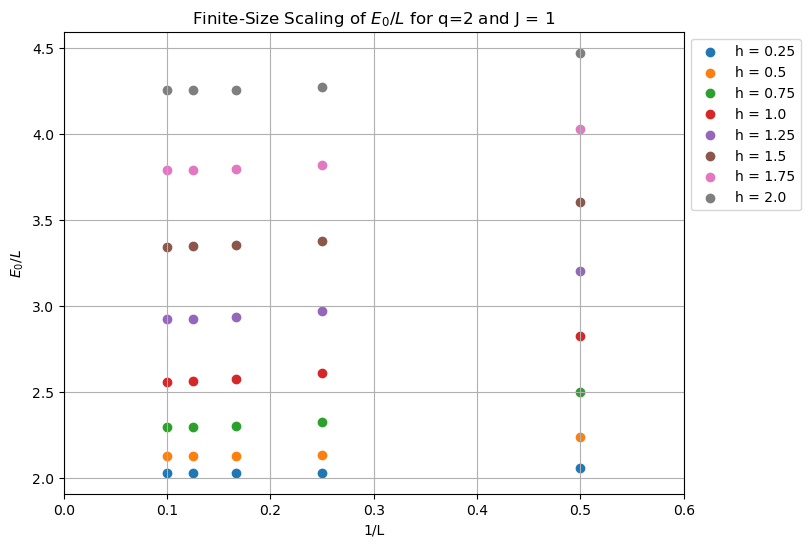

Total runtime: 9.37 seconds


In [11]:
q = 2
J = 1
h_values = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
L_values = np.array([2, 4, 6, 8, 10])

start_time = time.time()

inv_L = 1 / L_values  # Inverse system size (x-axis)
energies_per_L = np.zeros((len(h_values), len(L_values)))  # Store energies as 2D array

# Compute energies and store values
print("h\t1/L\tE0/L")  # Header for readability
print("="*25)
for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = np.abs(E0_per_site(q, J, h, L))  # Compute energy per site
        print(f"{h:.2f}\t{inv_L[j]:.4f}\t{energies_per_L[i, j]:.4f}")  # Print values

# Compute energies
for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = np.abs(E0_per_site(q, J, h, L))  # Store properly

# Plot each h separately
plt.figure(figsize=(8, 6)) 
for i, h in enumerate(h_values):
    plt.scatter(inv_L, energies_per_L[i], label=f"h = {h}")

plt.xlabel("1/L")
plt.ylabel("$E_0/L$")
plt.title(f"Finite-Size Scaling of $E_0/L$ for q={q} and J = {J}")
plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xlim(0, 0.6)  # Zoom in: x-axis from 0 to 1
plt.show()

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

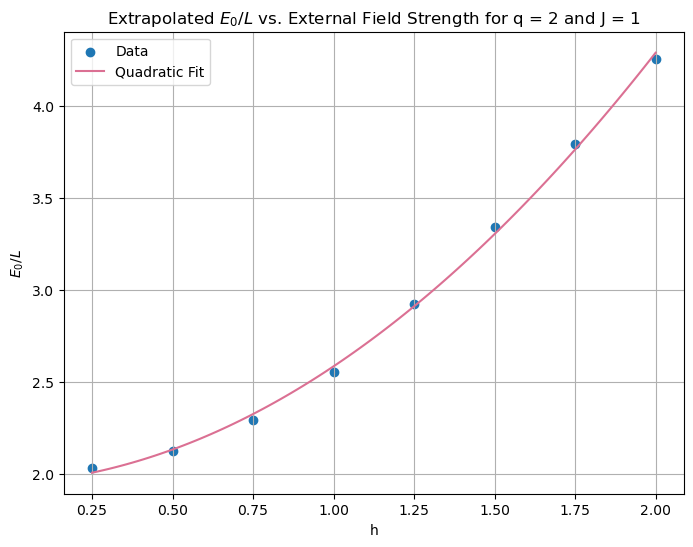

Total runtime: 0.73 seconds
[0.53362857 0.1041881  1.94778036]


In [11]:
q = 2
J = 1
h = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
E0_per_L = [2.0314, 2.1271, 2.2944, 2.5570, 2.9227, 3.3446, 3.7923, 4.2542]

start_time = time.time()
# Quadratic Fit
quad_coeffs = np.polyfit(h, E0_per_L, 2)
quad_fit = np.poly1d(quad_coeffs)
h_fine = np.linspace(min(h), max(h), 100)

plt.figure(figsize = (8,6))
plt.scatter(h, E0_per_L, label = "Data")
plt.plot(h_fine, quad_fit(h_fine), label="Quadratic Fit", color="palevioletred")
plt.xlabel("h")
plt.ylabel("$E_{0}/L$")
plt.title(f"Extrapolated $E_{0}/L$ vs. External Field Strength for q = {q} and J = {J}")
plt.legend(loc = "upper left", bbox_to_anchor=(0, 1))
plt.grid(True)
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")
print(quad_coeffs)

h	1/L	E0/L
0.25	0.5000	2.0447
0.25	0.2500	2.0220
0.25	0.1667	2.0218
0.25	0.1250	2.0218
0.25	0.1000	2.0218
0.50	0.5000	2.1861
0.50	0.2500	2.0964
0.50	0.1667	2.0921
0.50	0.1250	2.0917
0.50	0.1000	2.0917
0.75	0.5000	2.4212
0.75	0.2500	2.2476
0.75	0.1667	2.2264
0.75	0.1250	2.2220
0.75	0.1000	2.2208
1.00	0.5000	2.7321
1.00	0.2500	2.5055
1.00	0.1667	2.4665
1.00	0.1250	2.4531
1.00	0.1000	2.4469
1.25	0.5000	3.0975
1.25	0.2500	2.8626
1.25	0.1667	2.8302
1.25	0.1250	2.8222
1.25	0.1000	2.8198
1.50	0.5000	3.5000
1.50	0.2500	3.2798
1.50	0.1667	3.2589
1.50	0.1250	3.2557
1.50	0.1000	3.2551
1.75	0.5000	3.9276
1.75	0.2500	3.7280
1.75	0.1667	3.7148
1.75	0.1250	3.7134
1.75	0.1000	3.7132
2.00	0.5000	4.3723
2.00	0.2500	4.1928
2.00	0.1667	4.1842
2.00	0.1250	4.1835
2.00	0.1000	4.1834


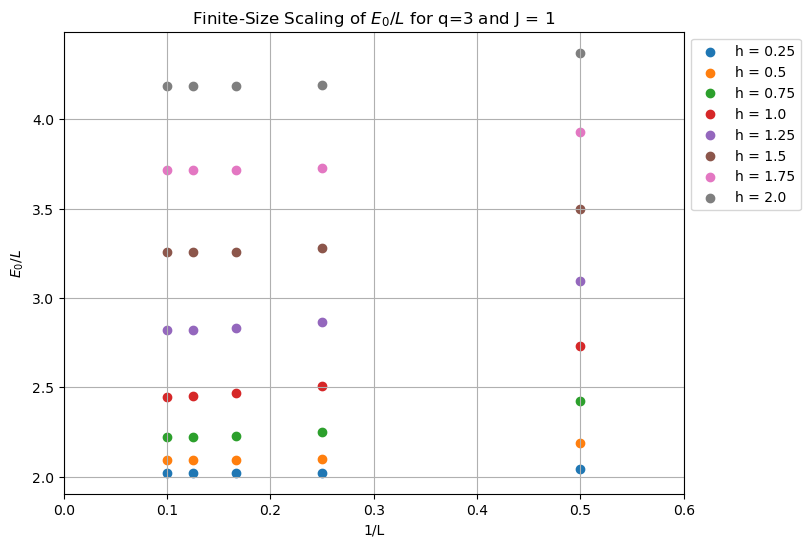

Total runtime: 29.25 seconds


In [117]:
q = 3
J = 1
h_values = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
L_values = np.array([2, 4, 6, 8, 10])

start_time = time.time()

inv_L = 1 / L_values  # Inverse system size (x-axis)
energies_per_L = np.zeros((len(h_values), len(L_values)))  # Store energies as 2D array

# Compute energies and store values
print("h\t1/L\tE0/L")  # Header for readability
print("="*25)
for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = np.abs(E0_per_site(q, J, h, L))  # Compute energy per site
        print(f"{h:.2f}\t{inv_L[j]:.4f}\t{energies_per_L[i, j]:.4f}")  # Print values

# Compute energies
for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = np.abs(E0_per_site(q, J, h, L))  # Store properly

# Plot each h separately
plt.figure(figsize=(8, 6)) 
for i, h in enumerate(h_values):
    plt.scatter(inv_L, energies_per_L[i], label=f"h = {h}")

plt.xlabel("1/L")
plt.ylabel("$E_0/L$")
plt.title(f"Finite-Size Scaling of $E_0/L$ for q={q} and J = {J}")
plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xlim(0, 0.6)  # Zoom in: x-axis from 0 to 1
plt.show()

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

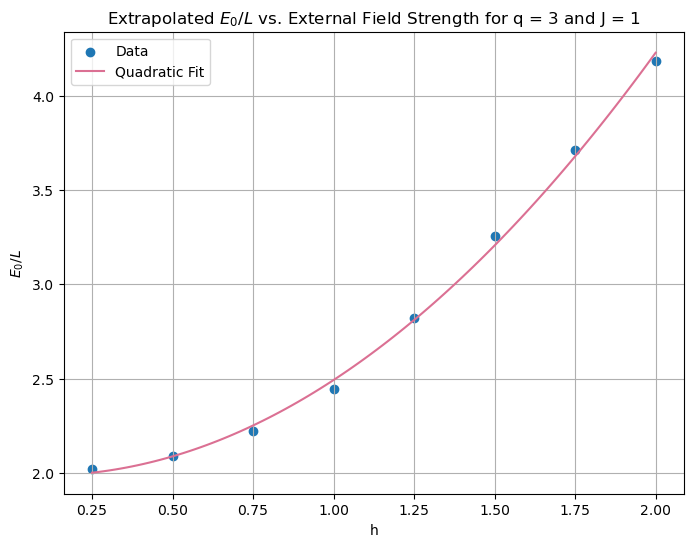

Total runtime: 0.33 seconds


In [118]:
q = 3
J = 1

h = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
E0_per_L = [2.0218, 2.0917, 2.2208, 2.4469, 2.8198, 3.2551, 3.7132, 4.1834]

start_time = time.time()
# Quadratic Fit
quad_coeffs = np.polyfit(h, E0_per_L, 2)
quad_fit = np.poly1d(quad_coeffs)
h_fine = np.linspace(min(h), max(h), 100)

plt.figure(figsize = (8,6))
plt.scatter(h, E0_per_L, label = "Data")
plt.plot(h_fine, quad_fit(h_fine), label="Quadratic Fit", color="palevioletred")
plt.xlabel("h")
plt.ylabel("$E_{0}/L$")
plt.title(f"Extrapolated $E_{0}/L$ vs. External Field Strength for q = {q} and J = {J}")
plt.legend(loc = "upper left", bbox_to_anchor=(0, 1))
plt.grid(True)
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

### Plots (Ground-State Energy Density)

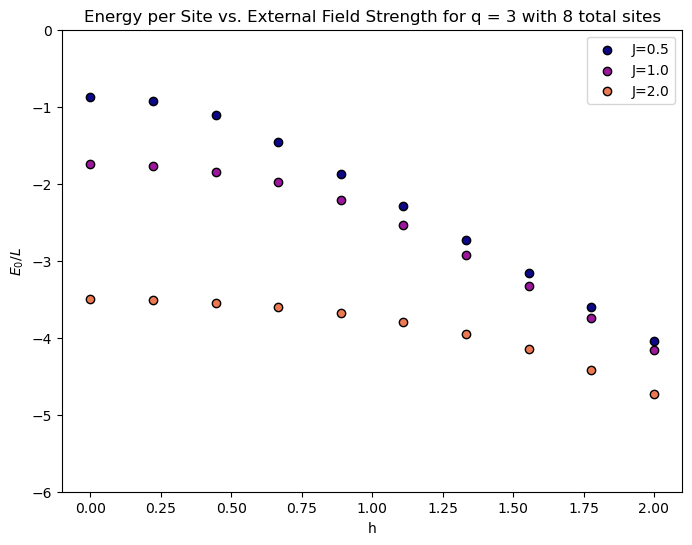

Total runtime: 9.45 seconds


In [12]:
# Parameters
L = 8
q = 3
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

### Plots (Energy Gap per Site)

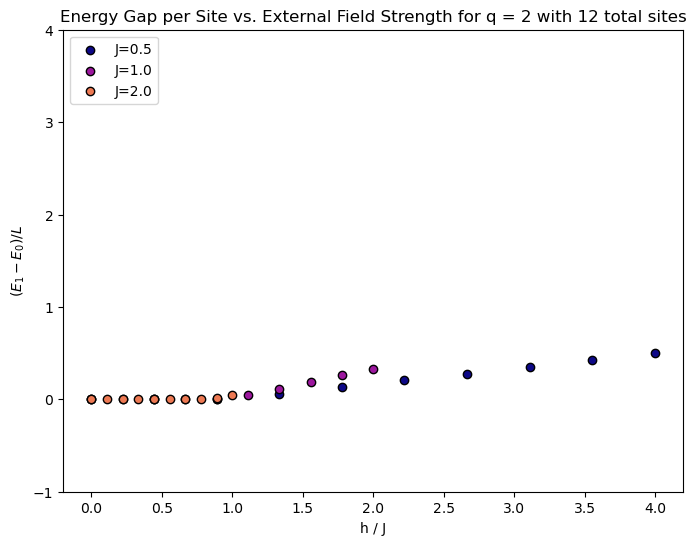

Total runtime: 13.16 seconds


In [29]:
# Parameters
L = 12
q = 2
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors


index = 0  # Color index tracker
for J in J_values:
    h_J = h_values / J
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_J, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h / J")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

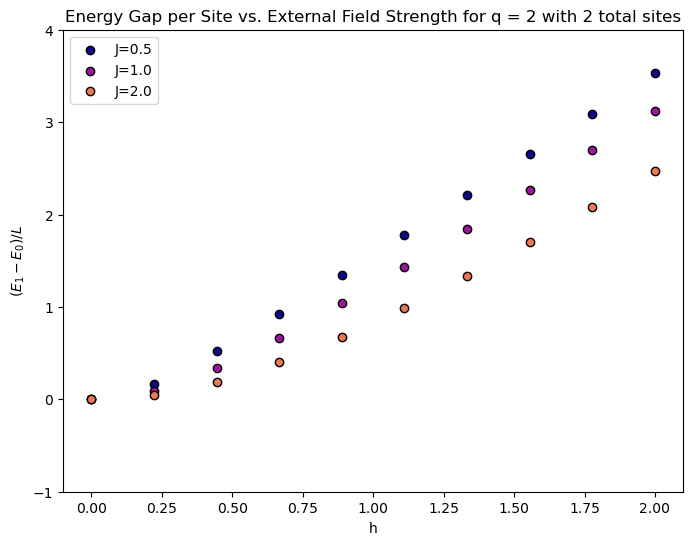

Total runtime: 0.61 seconds


In [14]:
# Parameters
L = 2
q = 2
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")